# House Appraisal with Multiple Inputs of Mixed Data
Predict value of house based on multiple inputs of mixed data. 
Types of data use:
- Numerical Data
    - Number of bedrooms
    - Number of bathrooms
    - Area (i.e., square footage)
    - Zip code
- Image Data (4 images)
    - Bedroom
    - Bathroom
    - Kitchen
    - Frontal view of the house
    
Following [Keras: Multiple Inputs and Mixed Data](https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/) tutorial.

## Import Packages

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals

# ML Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Helper libraries
import pandas as pd
import numpy as np
import glob
import cv2
import os
import locale


# Visualization libraries
import matplotlib.pyplot as plt

## Import Data

### Numerical Data

In [32]:
def load_house_attributes(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
    # determine (1) the unique zip codes and (2) the number of data
    # points with each zip code
    zipcodes = df["zipcode"].value_counts().keys().tolist()
    counts = df["zipcode"].value_counts().tolist()

    # loop over each of the unique zip codes and their corresponding
    # count
    for (zipcode, count) in zip(zipcodes, counts):
        # the zip code counts for our housing dataset is *extremely*
        # unbalanced (some only having 1 or 2 houses per zip code)
        # so let's sanitize our data by removing any houses with less
        # than 25 houses per zip code
        if count < 25:
            idxs = df[df["zipcode"] == zipcode].index
            df.drop(idxs, inplace=True)
 
    # return the data frame
    return df

inputPath = '/Users/josh/Projects/ML_Voyage/Tutorials/Datasets/Houses-dataset/Houses_Dataset'
#cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
#df = pd.read_csv(inputPath + "/HousesInfo.txt", sep=" ", header=None, names=cols)

df = load_house_attributes(inputPath + "/HousesInfo.txt")

### Image Data

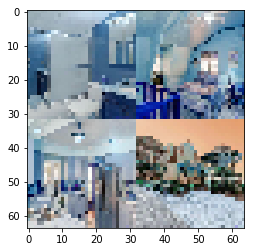

In [35]:
images = []
 
# loop over the indexes of the houses
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))
    
    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")
    
    # loop over the input house paths
    for housePath in housePaths:
        # load the input image, resize it to be 32 32, and then
        # update the list of input images
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)
        
    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
        
    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
 
plt.imshow(images[0])

def load_house_images(df, inputPath):
    # initialize our images array (i.e., the house images themselves)
    images = []
 
    # loop over the indexes of the houses
    for i in df.index.values:
        # find the four images for the house and sort the file paths,
        # ensuring the four are always in the *same order*
        basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
        housePaths = sorted(list(glob.glob(basePath)))
        
        # initialize our list of input images along with the output image
        # after *combining* the four input images
        inputImages = []
        outputImage = np.zeros((64, 64, 3), dtype="uint8")
 
        # loop over the input house paths
        for housePath in housePaths:
            # load the input image, resize it to be 32 32, and then
            # update the list of input images
            image = cv2.imread(housePath)
            image = cv2.resize(image, (32, 32))
            inputImages.append(image)
            
        # tile the four input images in the output image such the first
        # image goes in the top-right corner, the second image in the
        # top-left corner, the third image in the bottom-right corner,
        # and the final image in the bottom-left corner
        outputImage[0:32, 0:32] = inputImages[0]
        outputImage[0:32, 32:64] = inputImages[1]
        outputImage[32:64, 32:64] = inputImages[2]
        outputImage[32:64, 0:32] = inputImages[3]
 
        # add the tiled image to our set of images the network will be
        # trained on
        images.append(outputImage)
 
    # return our set of images
    return np.array(images)

images = load_house_images(df, inputPath)
images = images / 255.0

### Explore the Data

#### Numerical Data

In [43]:
print( "Shape of data: {}\n".format( df.shape ) )
print( "Minimum values:\n\tRooms = {0[0]:f}\n\tBaths = {0[1]:f}\n\tArea  = {0[2]:f}\n\tZip   = {0[3]:f}\n\tPrice = {0[4]:f}\n"
      .format( df.min() ) )
print( "Maximum values:\n\tRooms = {0[0]:f}\n\tBaths = {0[1]:f}\n\tArea  = {0[2]:f}\n\tZip   = {0[3]:f}\n\tPrice = {0[4]:f}\n"
      .format( df.max() ) )
print( "Number of unique values:\n\tRooms = {0[0]}\n\tBaths = {0[1]}\n\tArea  = {0[2]}\n\tZip   = {0[3]}\n\tPrice = {0[4]}\n"
      .format( df.nunique() ) )


Shape of data: (535, 5)

Minimum values:
	Rooms = 1.000000
	Baths = 1.000000
	Area  = 701.000000
	Zip   = 36372.000000
	Price = 22000.000000

Maximum values:
	Rooms = 10.000000
	Baths = 7.000000
	Area  = 9583.000000
	Zip   = 98021.000000
	Price = 5858000.000000

Number of unique values:
	Rooms = 9
	Baths = 14
	Area  = 435
	Zip   = 49
	Price = 369



##### Categorical Data

In [46]:
# Unique zip codes
zipcodes = df["zipcode"].value_counts().keys().tolist()

# Number of samples with each zip code
zip_counts = df["zipcode"].value_counts().tolist()

print( zipcodes )
print( zip_counts )

[92276, 93510, 93446, 92880, 94501, 91901, 92677, 94531, 85255, 96019, 93111, 92021, 85266, 81524, 95220, 92802, 85262, 62234, 62214, 98021, 85377, 60002, 91752, 81418, 62025, 92692, 92253, 60016, 93924, 90211, 90038, 93314, 90265, 93105, 92040, 62249, 95008, 91915, 62034, 85331, 94565, 94568, 92543, 60046, 62088, 81521, 36372, 93720, 90803]
[100, 60, 54, 49, 41, 32, 26, 22, 12, 12, 11, 11, 11, 11, 10, 9, 9, 7, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


##### Continuous Data

(array([175., 155., 105.,  69.,  20.,   6.,   0.,   2.,   1.,   2.]),
 array([ 701. , 1589.2, 2477.4, 3365.6, 4253.8, 5142. , 6030.2, 6918.4,
        7806.6, 8694.8, 9583. ]),
 <a list of 10 Patch objects>)

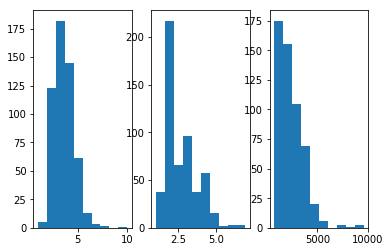

In [54]:
# initialize the column names of the continuous data
continuous = ["bedrooms", "bathrooms", "area"]

# Histogram of values
plt.subplot(131)
plt.hist(df["bedrooms"])
plt.subplot(132)
plt.hist(df["bathrooms"])
plt.subplot(133)
plt.hist(df["area"])



### Prepare the Data

In [36]:
def process_house_attributes(df, train, test):
    # initialize the column names of the continuous data
    continuous = ["bedrooms", "bathrooms", "area"]
 
    # performin min-max scaling each continuous feature column to
    # the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    # one-hot encode the zip code categorical data (by definition of
    # one-hot encoding, all output features are now in the range [0, 1])
    zipBinarizer = LabelBinarizer().fit(df["zipcode"])
    trainCategorical = zipBinarizer.transform(train["zipcode"])
    testCategorical = zipBinarizer.transform(test["zipcode"])
 
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
 
    # return the concatenated training and testing data
    return (trainX, testX)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
 
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
 
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
(trainAttrX, testAttrX) = process_house_attributes(df,trainAttrX, testAttrX)

/Users/josh/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Define the Model

### Numerical Data Branch

In [26]:
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
 
    # return our model
    return model

### Image Data Branch

In [27]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)
 
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
 
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

### Merge Branches

In [37]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)
 
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
 
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
 
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

### Select Loss Function and Optimizer

In [38]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

## Train the Model

In [39]:
model.fit( [trainAttrX, trainImagesX], trainY,
           validation_data=([testAttrX, testImagesX], testY),
           epochs=200, batch_size=8 )

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 4s 13ms/sample - loss: 1019.9066 - val_loss: 284.0295
Epoch 2/200
271/271 [==============================] - 1s 5ms/sample - loss: 466.9328 - val_loss: 924.3825
Epoch 3/200
271/271 [==============================] - 1s 5ms/sample - loss: 283.9524 - val_loss: 1808.4016
Epoch 4/200
271/271 [==============================] - 1s 5ms/sample - loss: 212.5448 - val_loss: 2381.8650
Epoch 5/200
271/271 [==============================] - 1s 5ms/sample - loss: 144.6842 - val_loss: 2948.3783
Epoch 6/200
271/271 [==============================] - 1s 5ms/sample - loss: 143.7708 - val_loss: 3577.6957
Epoch 7/200
271/271 [==============================] - 1s 5ms/sample - loss: 122.5113 - val_loss: 3216.1834
Epoch 8/200
271/271 [==============================] - 1s 5ms/sample - loss: 94.8506 - val_loss: 2579.6688
Epoch 9/200
271/271 [==============================] - 1s 5ms/sample - loss: 117.7591 - val_

271/271 [==============================] - 1s 4ms/sample - loss: 22.3073 - val_loss: 22.6053
Epoch 78/200
271/271 [==============================] - 1s 4ms/sample - loss: 22.1660 - val_loss: 22.8739
Epoch 79/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.6923 - val_loss: 22.4566
Epoch 80/200
271/271 [==============================] - 1s 4ms/sample - loss: 22.0155 - val_loss: 21.2315
Epoch 81/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.6477 - val_loss: 20.6274
Epoch 82/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.8265 - val_loss: 22.5609
Epoch 83/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.1903 - val_loss: 22.3258
Epoch 84/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.7429 - val_loss: 21.9674
Epoch 85/200
271/271 [==============================] - 1s 4ms/sample - loss: 21.5454 - val_loss: 22.0908
Epoch 86/200
271/271 [==============================] - 1s 

Epoch 154/200
271/271 [==============================] - 1s 4ms/sample - loss: 17.3916 - val_loss: 20.8776
Epoch 155/200
271/271 [==============================] - 1s 4ms/sample - loss: 17.3466 - val_loss: 24.0368
Epoch 156/200
271/271 [==============================] - 1s 4ms/sample - loss: 18.3722 - val_loss: 24.0870
Epoch 157/200
271/271 [==============================] - 1s 4ms/sample - loss: 17.1539 - val_loss: 24.1225
Epoch 158/200
271/271 [==============================] - 1s 4ms/sample - loss: 17.5371 - val_loss: 25.5442
Epoch 159/200
271/271 [==============================] - 1s 4ms/sample - loss: 17.9673 - val_loss: 21.4089
Epoch 160/200
271/271 [==============================] - 1s 4ms/sample - loss: 18.1052 - val_loss: 21.3604
Epoch 161/200
271/271 [==============================] - 1s 4ms/sample - loss: 18.1360 - val_loss: 21.2000
Epoch 162/200
271/271 [==============================] - 1s 5ms/sample - loss: 16.3129 - val_loss: 23.0744
Epoch 163/200
271/271 [==============

## Evaluate the model

In [44]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([testAttrX, testImagesX])

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 22.93%, std: 20.23%
